## Problem Statement:


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

Loads all the data. We have a train set, a test set and 4 supported datasets. These additional datasets may be helpful in building our model. 

In [2]:
train = pd.read_csv("train.csv")
holidays = pd.read_csv("holidays_events.csv")
transactions = pd.read_csv("transactions.csv")
oil = pd.read_csv("oil.csv")
store = pd.read_csv("stores.csv")
test = pd.read_csv("test.csv")


## Data Exploration:

First, let's check the columns of all the files to have the first overview of our data.

In [79]:
train.head(2)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


In [95]:
holidays.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [229]:
oil.head(2)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


In [99]:
transactions.head(2)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111


In [101]:
store.head(2)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


First we do some data description and checking for missing values in train set. We see that there is not any missing values. 

In [288]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [17]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [54]:
# check for missing values:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Let's rename columns of train and test sets, convert 'date' column into datetime

In [3]:
train['date'] = pd.to_datetime(train["date"])
test['date'] = pd.to_datetime(test["date"])
train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
test.rename(columns={'date': 'ds'}, inplace=True)


## Model Selection

Since we have 54 different stores and 33 family. I first will try to use Facebook Prophet to forecast number of sale for each store of each family to see how well this only train data to forecast the sales. 

In [29]:
print(f' number of stores:', len(train['store_nbr'].unique()))
print(f' number of family:', len(train['family'].unique()))

 number of stores: 54
 number of family: 33


First I will filter to get all information of store 1 with family named 'AUTOMOTIVE' and do some visulization to identify trends, seasonality and pattern of this data.

In [4]:
train1_auto = train[train['store_nbr']==1][train['family']=='AUTOMOTIVE']

train1_auto = train1_auto.set_index('ds')

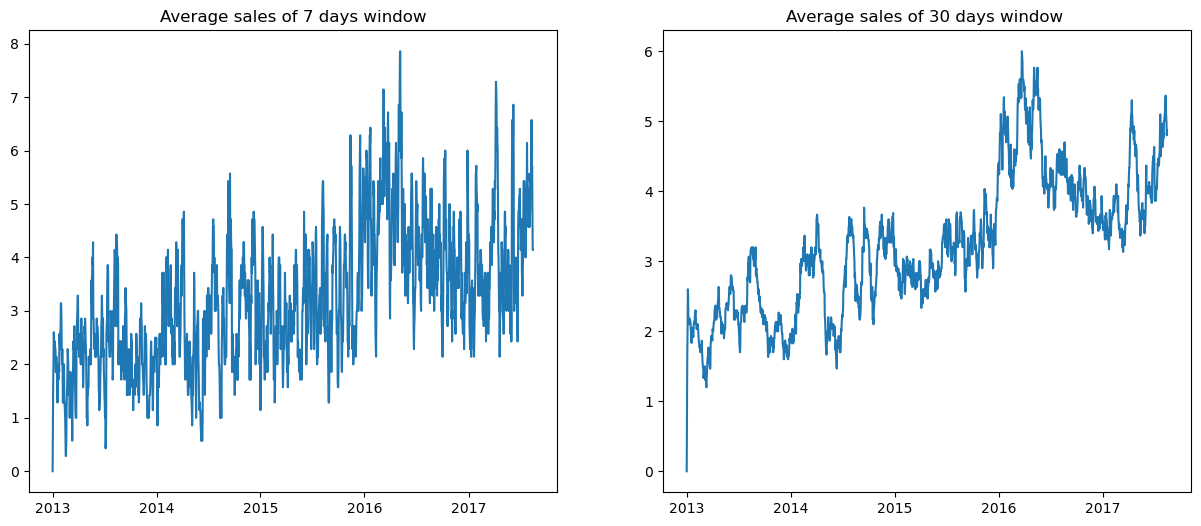

In [5]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(15, 6))
ax[1].plot(train1_auto.index, train1_auto['y'].rolling('30D').mean());
ax[0].plot(train1_auto.index, train1_auto['y'].rolling('7D').mean())
ax[1].set_title("Average sales of 30 days window ")
ax[0].set_title("Average sales of 7 days window")
plt.show()


Trends are not showning clearly from the plot of average sales of 7 days windown but from the plot of 30 days windown average sales, we can see that sales increased over time, and it usually lowest at the beginning of the year.
Let's use fbprophet to train our data and forecast the sales of Automotive family of all store number 1 in the test set. 

In [101]:
train1_auto.reset_index(inplace=True)

test1_auto = test[test['family']=='AUTOMOTIVE'][test['store_nbr']==1]


In [104]:
train1_auto = train1_auto[['ds', 'y', 'onpromotion']]
train1_auto_p = train1_auto.iloc[:-15, :]
test_last_15days = train1_auto.iloc[-15:, :][['ds', 'onpromotion']]

Fb prophet have option to use holiday as one of its parameter, so I added the column 'type' in holidays dataset. We have to rename the columns name as prophet requirements. 

In [91]:
holidays.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [380]:
holidays_rename = holidays.rename(columns={'date': 'ds', 'type': 'holiday'})

In [9]:
model = Prophet(holidays = holidays_rename)
model.add_regressor('onpromotion', standardize = False)

model.fit(train1_auto_p)

13:02:53 - cmdstanpy - INFO - Chain [1] start processing
13:02:53 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
forecast1_auto = model.predict(test1)
forecast1_auto = forecast1_auto[['ds', 'yhat']]
forecast1_auto = train1_auto.iloc[-15:, :].merge(forecast1_auto)
forecast1_auto

,ds,y,onpromotion,yhat
0,2017-08-01,5.0,0,5.442085
1,2017-08-02,4.0,0,5.072846
2,2017-08-03,3.0,0,4.580153
3,2017-08-04,8.0,0,5.326902
4,2017-08-05,5.0,0,4.926737
5,2017-08-06,6.0,0,2.776078
6,2017-08-07,7.0,0,4.630030
7,2017-08-08,4.0,0,5.172081
8,2017-08-09,7.0,0,4.778782
9,2017-08-10,9.0,0,4.072905


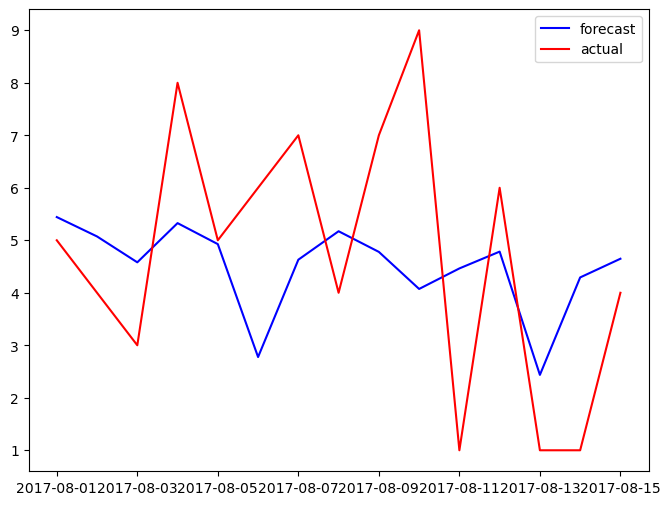

In [11]:
plt.figure(figsize=(8,6))
plt.plot(forecast1_auto['ds'], forecast1_auto['yhat'], color = 'blue', label = 'forecast')
plt.plot(forecast1_auto['ds'], forecast1_auto['y'], color = 'red', label = 'actual')
plt.legend()

In [12]:

test_mae = mean_absolute_error(forecast1_auto.yhat, forecast1_auto.y)
test_mape = mean_absolute_percentage_error(forecast1_auto.yhat, forecast1_auto.y)
test_mape

0.4836607820680501

Above is the plot of actual and forecast sales for the last 15 days in train data. We achieve the mean absolute error 1.98. We can see from the plot that some days we can forecast the trend but other days we are off the actual trends. Next I will ad the oil price from oil dataset and train the model again. Since there are some missing values in this dataset, I will use fill backward method to fill the missing data.
and check if there is relationship b/t oil price and sales:

In [13]:
oil.rename(columns = {'date': 'ds', 'dcoilwtico': 'oil_price'}, inplace = True)
oil['ds'] = pd.to_datetime(oil["ds"])


In [58]:

train1_auto_oil = oil.set_index('ds').join(train1_auto.set_index('ds'), on = 'ds', how = 'right')
train1_auto_oil.fillna(method = 'bfill', inplace = True)
#train1_auto['oil_price'] = oil['dcoilwtico']
train1_auto_oil_p = train1_auto_oil.iloc[:-15, :]
test1_auto_oil_p = train1_auto_oil.iloc[-15:, :][['ds', 'oil_price', 'onpromotion']]


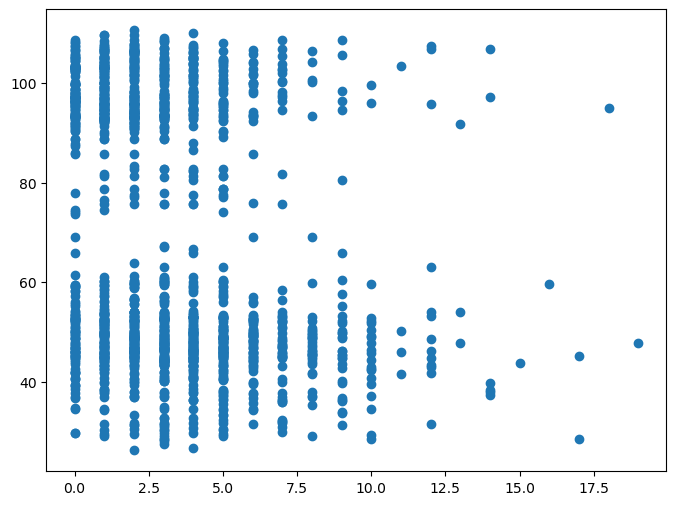

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(train1_auto_oil_p['y'], train1_auto_oil_p['oil_price'])

From the scatter plot we can not see that there aren't any relationship b/t oil price and sales. So I don't expect there are any improve in our forecasting when adding oil price as another variables. 

13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute percetage error:  0.478931694925879


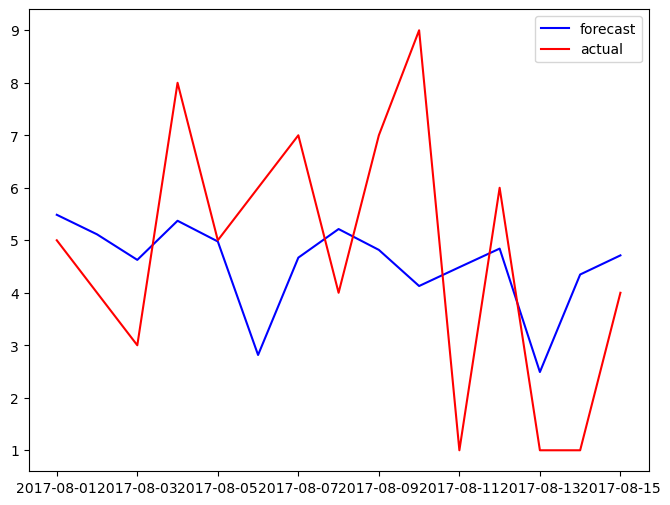

In [17]:
model = Prophet(holidays = holidays_rename)
model.add_regressor('onpromotion')
model.add_regressor('oil_price')
model.fit(train1_auto_oil_p)
forecast1_auto = model.predict(test1_auto_oil_p)
forecast1_auto = forecast1_auto[['ds', 'yhat']]
forecast1_auto = train1_auto_oil.iloc[-15:, :].merge(forecast1_auto)

plt.figure(figsize=(8,6))
plt.plot(forecast1_auto['ds'], forecast1_auto['yhat'], color = 'blue', label = 'forecast')
plt.plot(forecast1_auto['ds'], forecast1_auto['y'], color = 'red', label = 'actual')
plt.legend()
test_mape = mean_absolute_percentage_error(forecast1_auto.yhat, forecast1_auto.y)
print(f'Mean absolute percetage error: ', test_mape)

As I expected, the model with added oil price feature have very little improvement compare to previous model. 
Next step, let's create features such as day of week, quarter, month, day of year,... and fit to Xgboost model to see if we can improve the mean absolute percentage error.

In [18]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    #df['ds'] = df.index
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [114]:
test1_auto = train1_auto.iloc[-15:, :][['ds', 'y', 'onpromotion']]
#test_last_15days = train1_auto.iloc[-15:, :][['ds', 'onpromotion']]

In [146]:
X_train_add_feature, y_train_add_feature = create_features(train1_auto_p, label = 'y')
X_test_add_feature, y_test_add_feature = create_features(test1_auto, label = 'y')

In [149]:
import numpy as np
train1_auto_oil_p.set_index('ds', inplace = True)
train1_auto_oil_p.index = np.arange(1669)
X_train_add_feature['oil_price'] = train1_auto_oil_p.oil_price

X_train_add_feature['onpromotion'] = train1_auto_oil_p.onpromotion


In [152]:
test1_auto_oil_p.set_index('ds', inplace = True)
test1_auto_oil_p.index = np.arange(1669, 1684)
X_test_add_feature['oil_price'] = test1_auto_oil_p.oil_price

X_test_add_feature['onpromotion'] = test1_auto_oil_p.onpromotion
X_test_add_feature

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,oil_price,onpromotion
1669,1,3,8,2017,213,1,31,49.19,0
1670,2,3,8,2017,214,2,31,49.60,0
1671,3,3,8,2017,215,3,31,49.03,0
1672,4,3,8,2017,216,4,31,49.57,0
1673,5,3,8,2017,217,5,31,49.37,0
1674,6,3,8,2017,218,6,31,49.37,0
1675,0,3,8,2017,219,7,32,49.37,0
1676,1,3,8,2017,220,8,32,49.07,0
1677,2,3,8,2017,221,9,32,49.59,0
1678,3,3,8,2017,222,10,32,48.54,0


In [23]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [156]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train_add_feature, y_train_add_feature,
        eval_set=[(X_train_add_feature, y_train_add_feature), (X_test_add_feature, y_test_add_feature)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

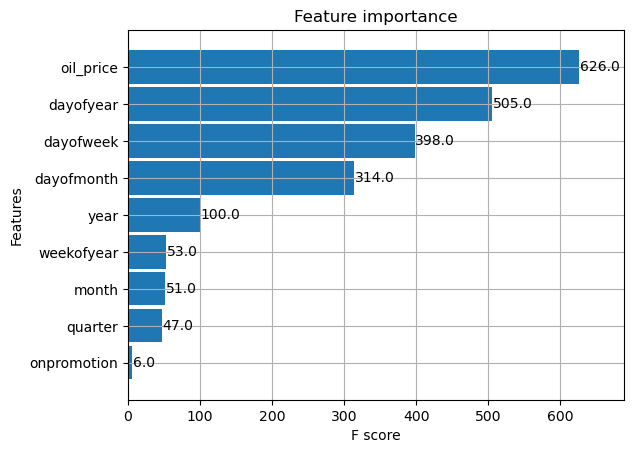

In [157]:
_ = plot_importance(model, height=0.9)

From the plot above, the most important feature is oil_price, follow by it is day of year, next is day of week and day of month.

In [160]:
test1_auto['Prediction'] = model.predict(X_test_add_feature)
forecast_all = pd.concat([train1_auto, test1_auto], sort=False)

Mean absolute percetage error:  1.0850883251592909


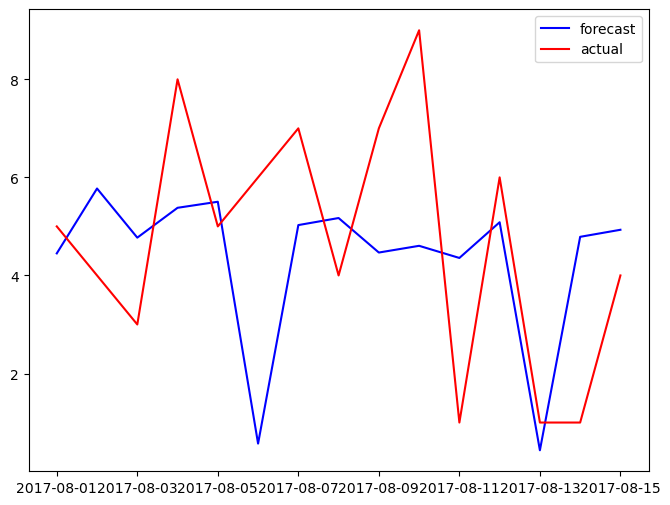

In [161]:
plt.figure(figsize=(8,6))
plt.plot(test1_auto['ds'], test1_auto['Prediction'], color = 'blue', label = 'forecast')
plt.plot(test1_auto['ds'], test1_auto['y'], color = 'red', label = 'actual')
plt.legend()
test_mape = mean_absolute_percentage_error(test1_auto.Prediction, test1_auto.y)
print(f'Mean absolute percetage error: ', test_mape)

The mean absolute percentage error from Xgboost is very high compare to the result from facebook Prophet model.
Because of this result, next step I will forecast each family at each store using Prophet model.

In [214]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [392]:
def get_forecasting(train, oil, store_num):
    prediction = {}
    test_mape = {}
    list_family = train.family.unique()
    df = train[train['store_nbr']==store_num]

    for family in list_family:
        family_df = df.loc[train['family'] == family]
        family_oil = oil.set_index('ds').join(family_df.set_index('ds'), on = 'ds', how = 'right')
        family_oil.fillna(method = 'bfill', inplace = True)
        train_family_df = family_oil.iloc[:-15, :]
        test_family_df = family_oil.iloc[-15:, :][['ds', 'oil_price', 'onpromotion']]
        model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0, holidays = holidays_rename)
        model.add_regressor('onpromotion')
        model.add_regressor('oil_price')
        model.fit(train_family_df)
        forecast = model.predict(test_family_df)
        forecast= forecast[['ds', 'yhat']]
        forecast = family_oil.iloc[-15:, :].merge(forecast)
        test_mae = mean_absolute_error(forecast.yhat, forecast.y)
        mape = mean_absolute_percentage_error(forecast.yhat, forecast.y)
        prediction[family] = forecast
        test_mape[family] = mape
    return (prediction, test_mape)

In [393]:

result = get_forecasting(train, oil, 1)

Below are the mean absolute percentage error of all family in store 1. We can see that many of them got very low mape, which are smaller than 0.2%, such as Beverages, Bread/bakery, Cleaning, Dairy, Deli,...Beside that, there are some families have very high mape, such as Books, Frozen foods, Home appliances, Lingerie, School and office supplies. These families have many 0 in historical selling. 

In [405]:
result[1]

{'AUTOMOTIVE': 0.4765480923776002,
 'BABY CARE': 0.0,
 'BEAUTY': 0.416252967443903,
 'BEVERAGES': 0.14214111924694653,
 'BOOKS': 1.0,
 'BREAD/BAKERY': 0.16620922095082855,
 'CELEBRATION': 0.45415197322574474,
 'CLEANING': 0.15943496665638698,
 'DAIRY': 0.12084453391560591,
 'DELI': 0.12604494495727403,
 'EGGS': 0.14999645801260672,
 'FROZEN FOODS': 0.5128077759920077,
 'GROCERY I': 0.14074903459277877,
 'GROCERY II': 0.17711994464523087,
 'HARDWARE': 0.6234632739310337,
 'HOME AND KITCHEN I': 0.5561594823214694,
 'HOME AND KITCHEN II': 0.32644389913075317,
 'HOME APPLIANCES': 1.0,
 'HOME CARE': 0.1764965799708375,
 'LADIESWEAR': 0.3532889243069406,
 'LAWN AND GARDEN': 0.3059361084758845,
 'LINGERIE': 1.0822874953247414,
 'LIQUOR,WINE,BEER': 4.180272688550844,
 'MAGAZINES': 0.4287557703009014,
 'MEATS': 0.2388179907398761,
 'PERSONAL CARE': 0.2273837070689045,
 'PET SUPPLIES': 0.37662673674275715,
 'PLAYERS AND ELECTRONICS': 0.4328349573137314,
 'POULTRY': 0.12796481359463277,
 'PREPARE

Below are the plots of forecast vs actual data for each family in store 1 for last 15 days in train data.

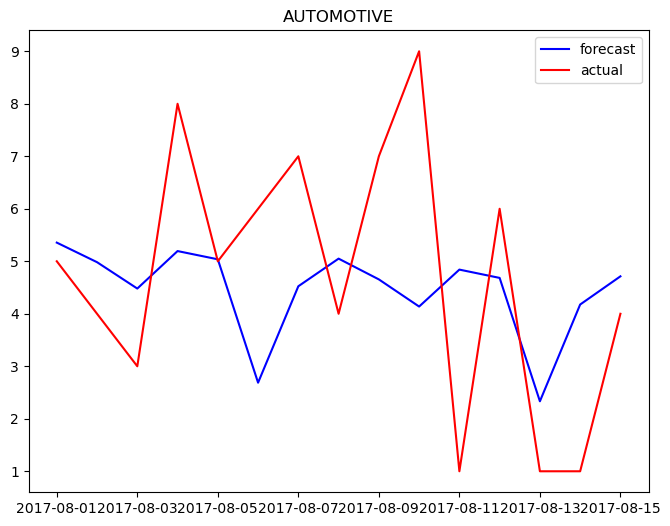

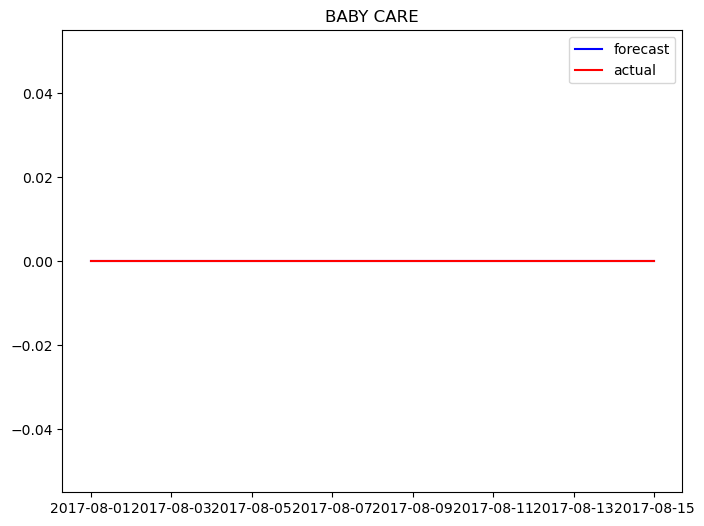

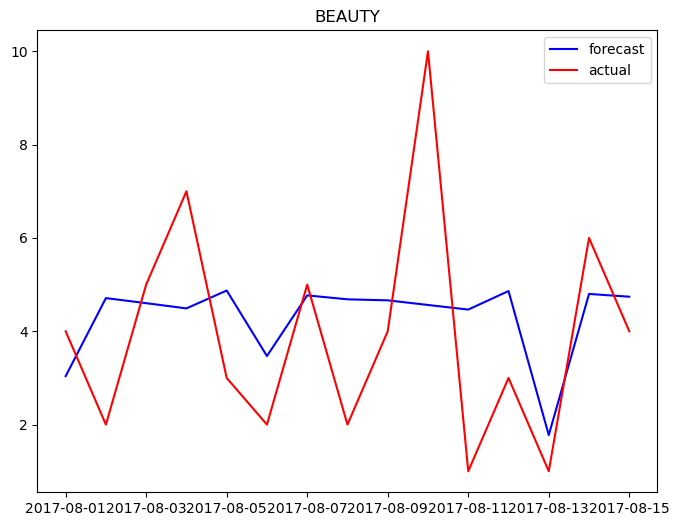

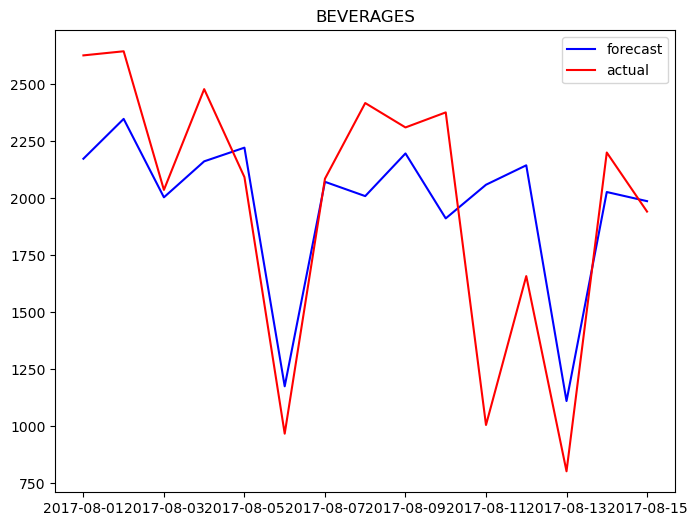

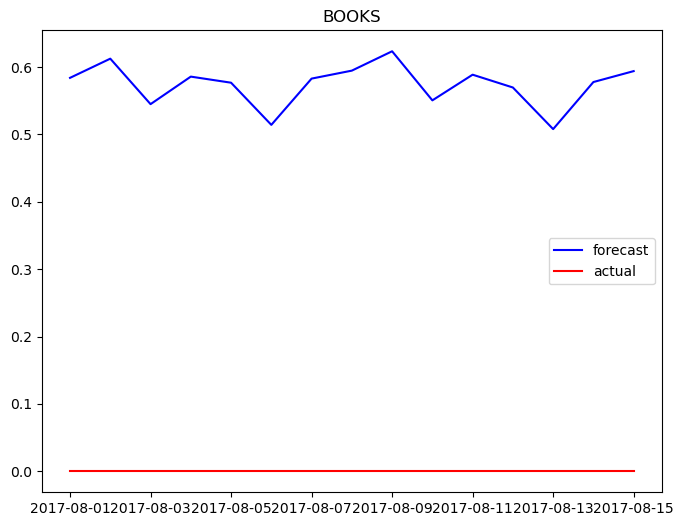

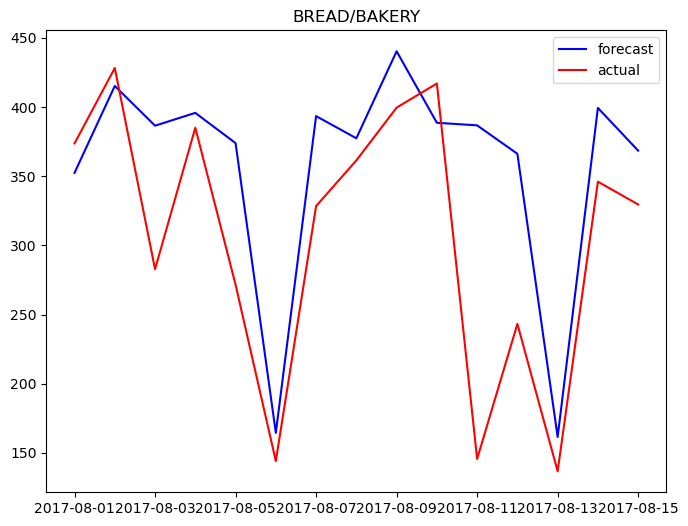

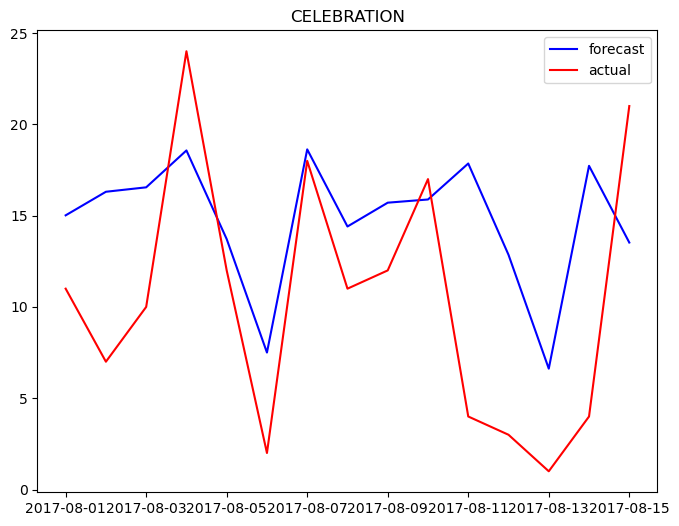

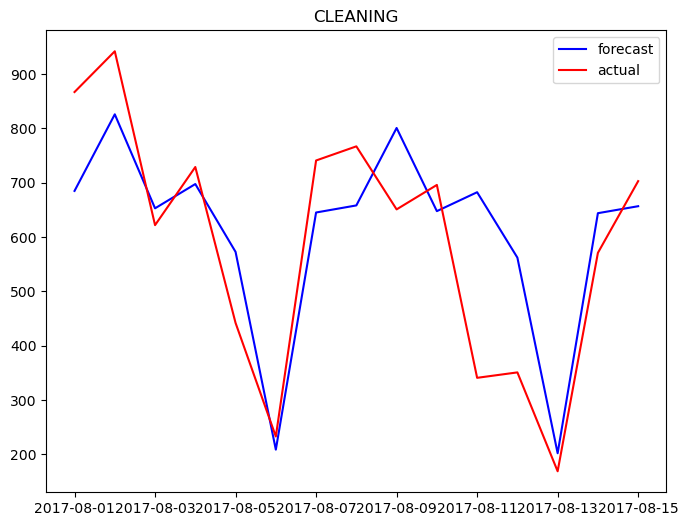

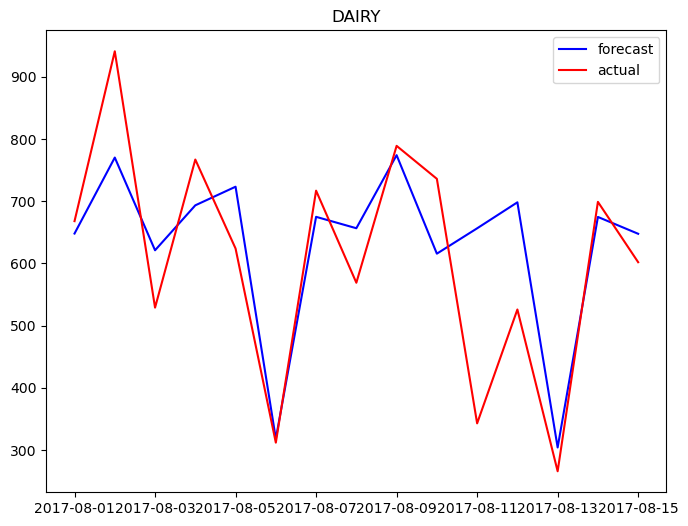

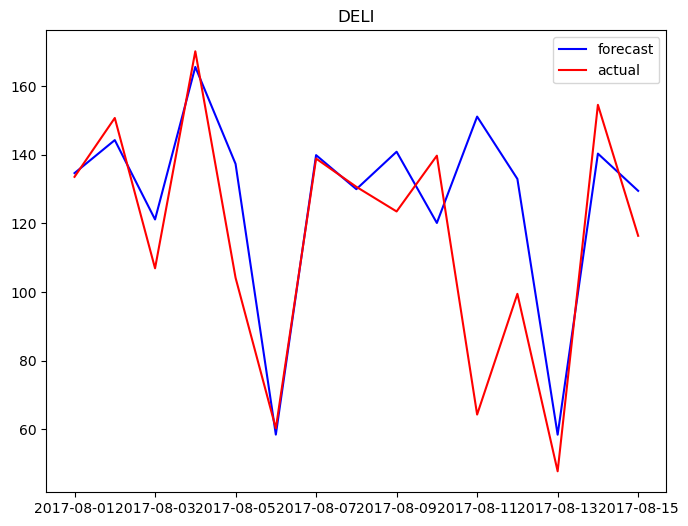

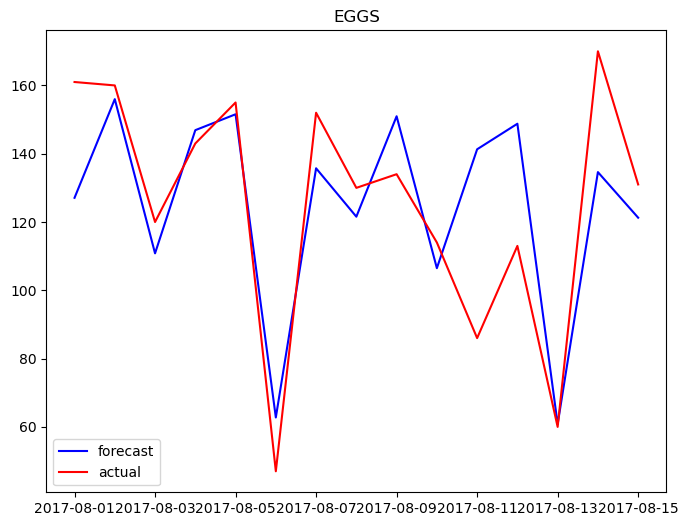

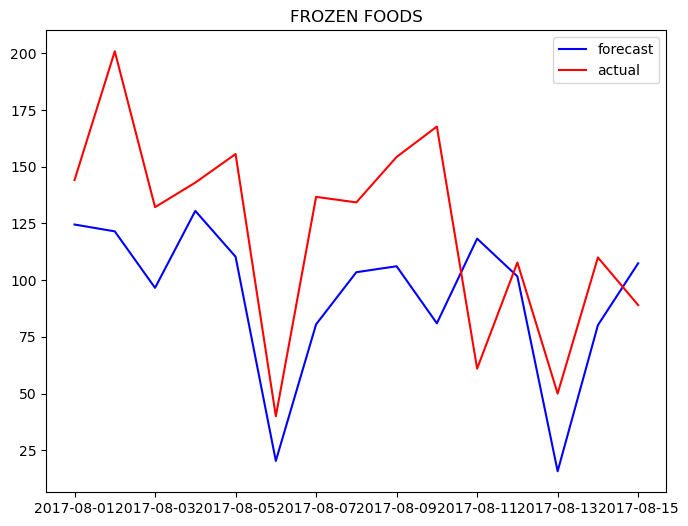

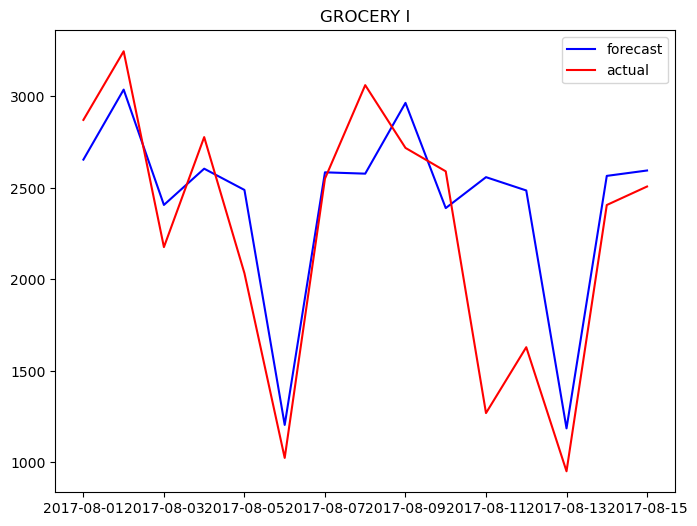

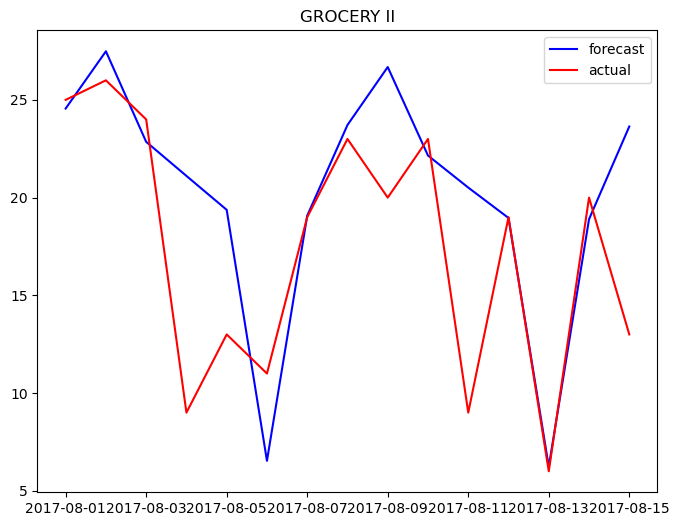

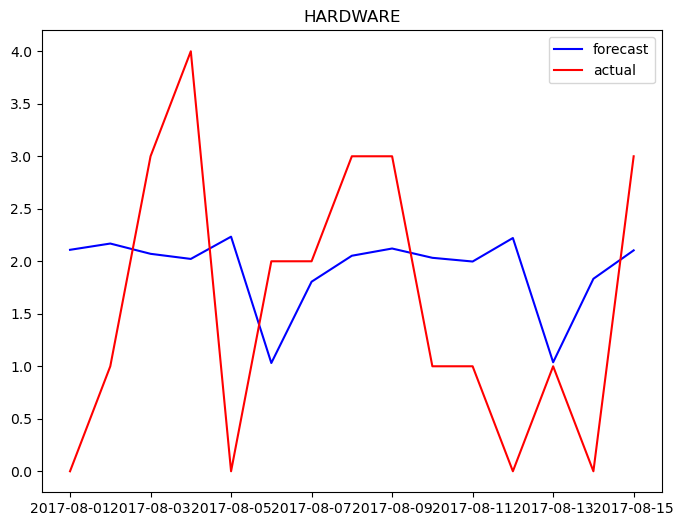

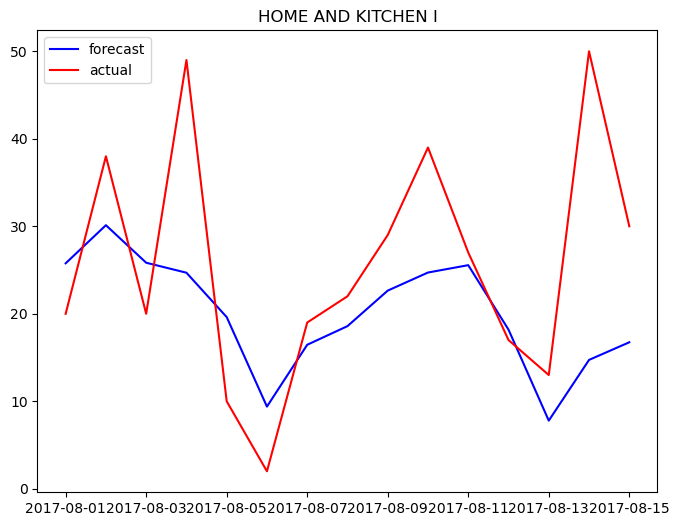

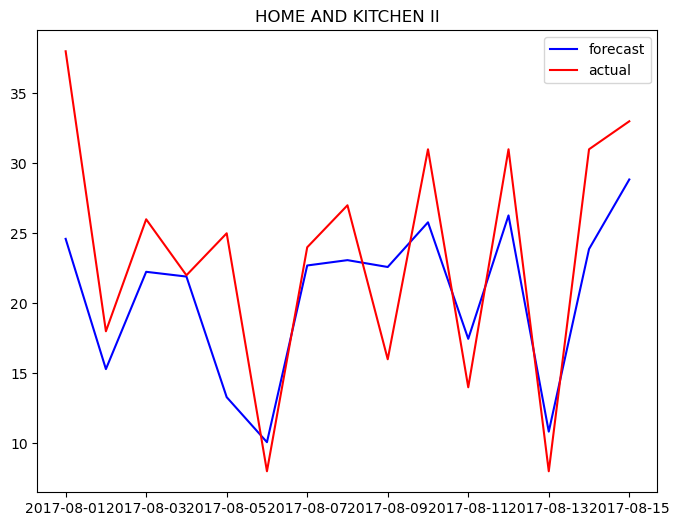

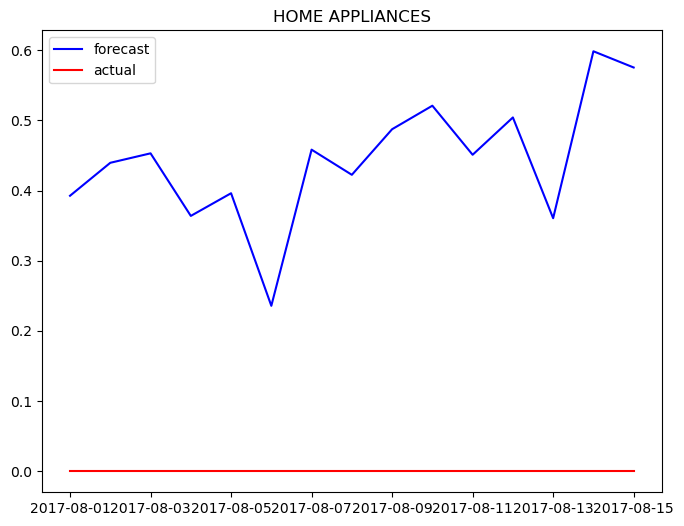

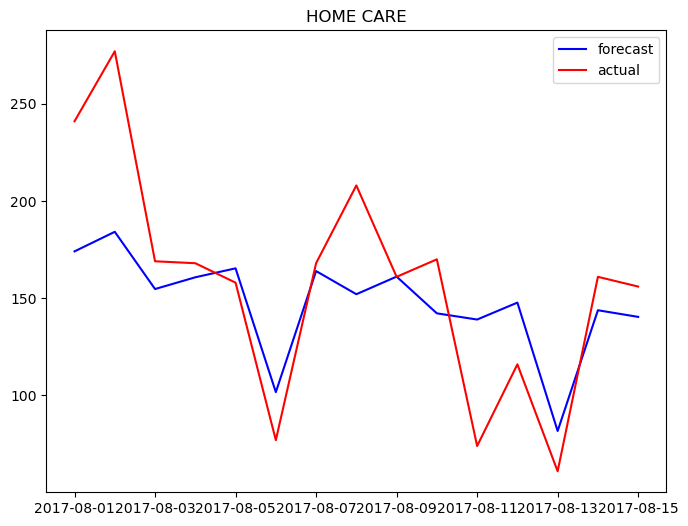

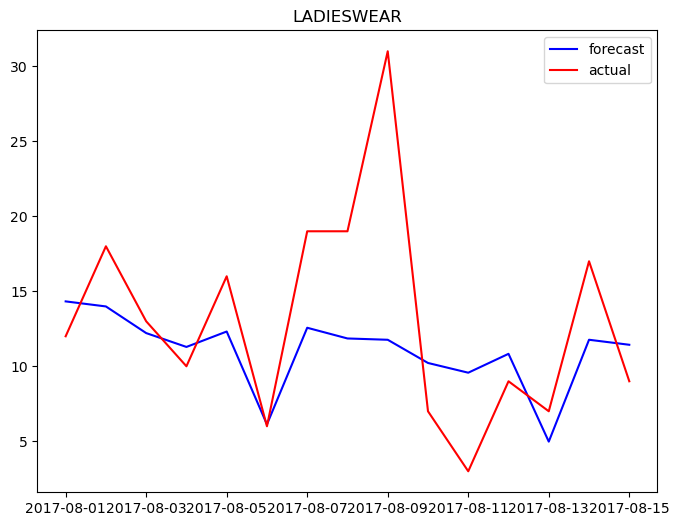

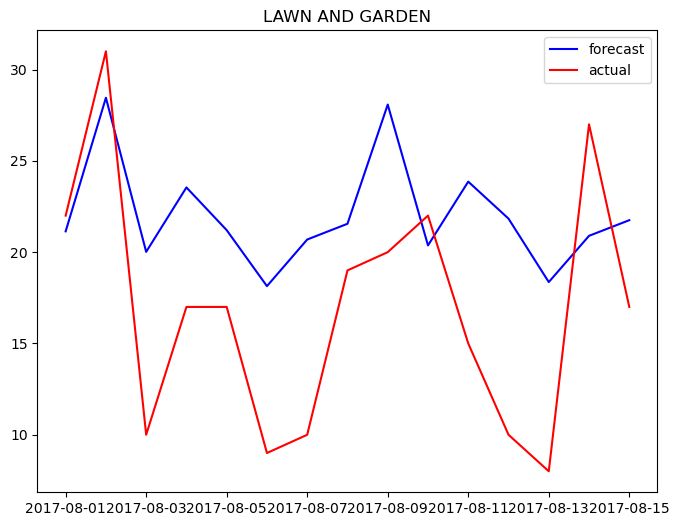

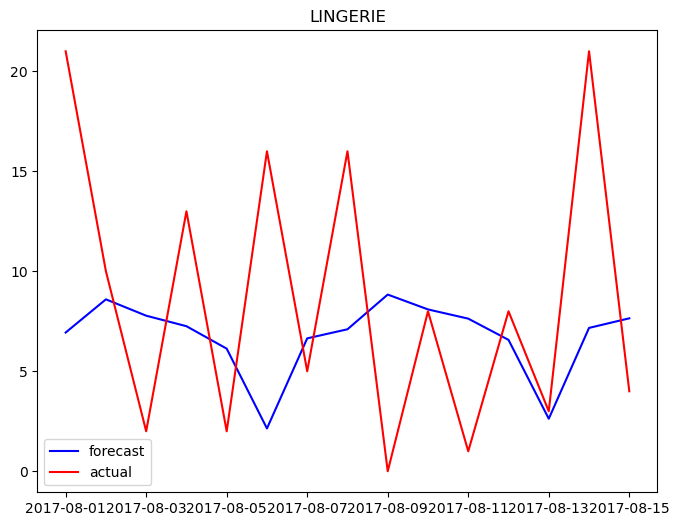

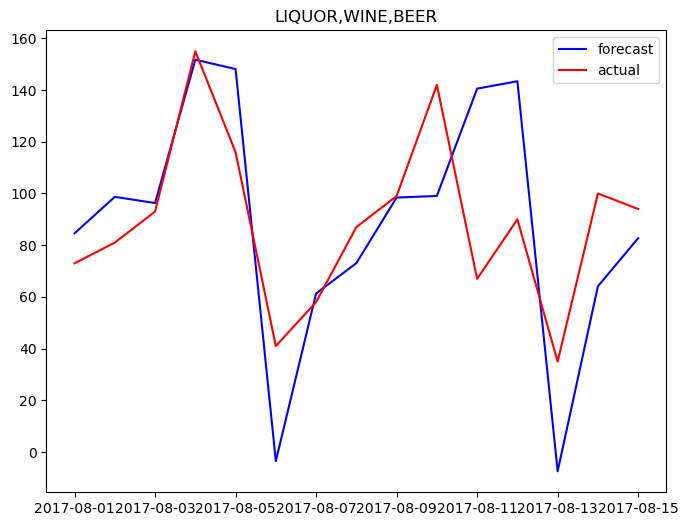

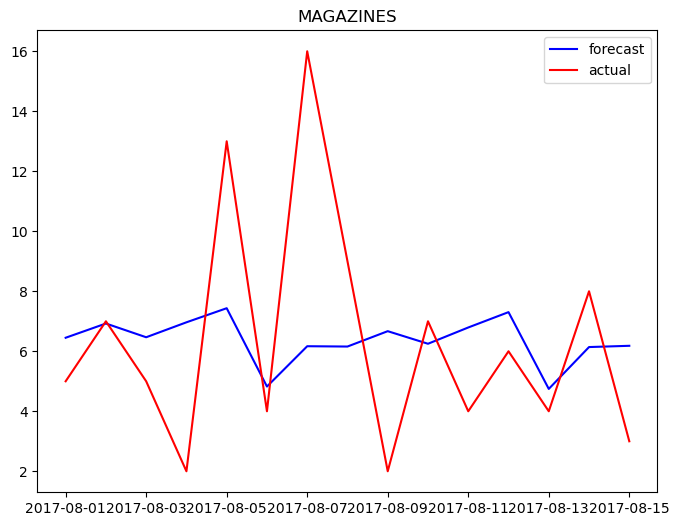

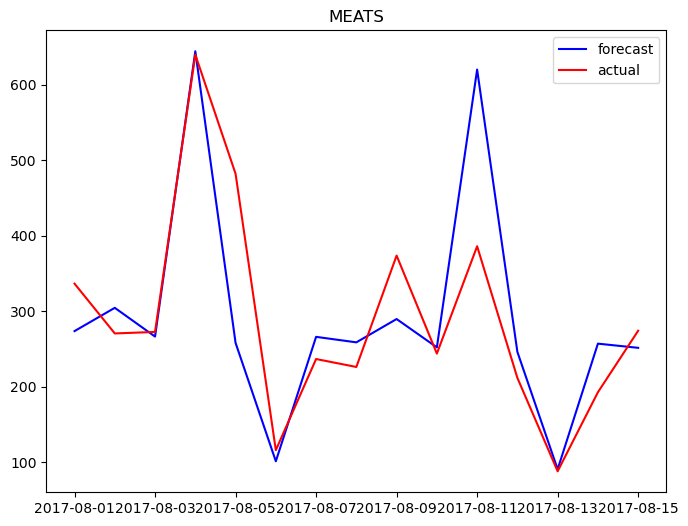

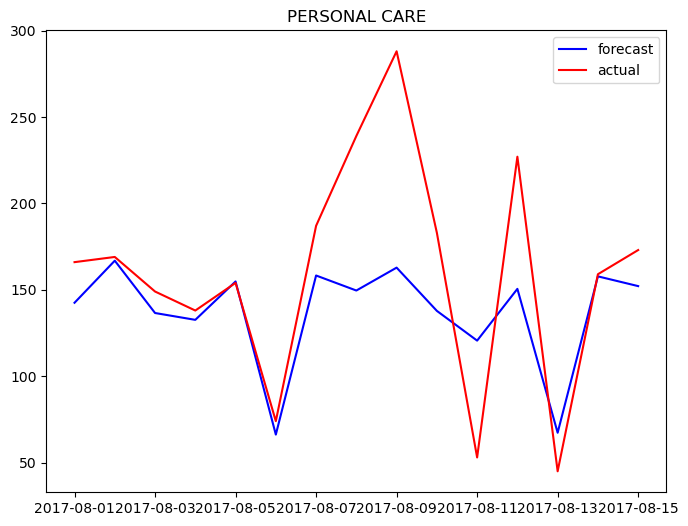

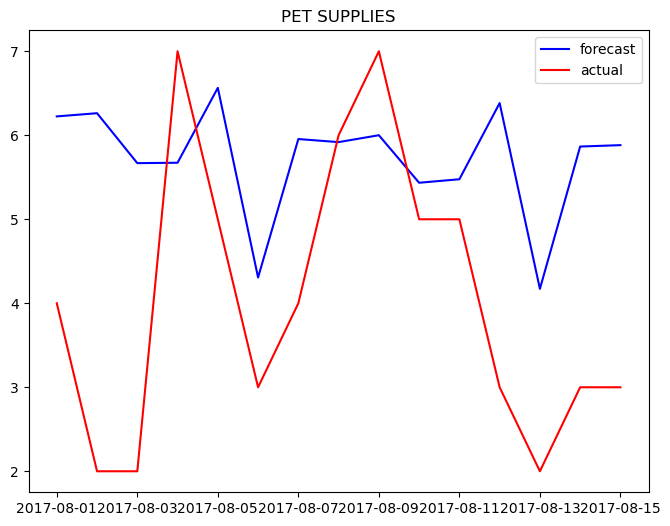

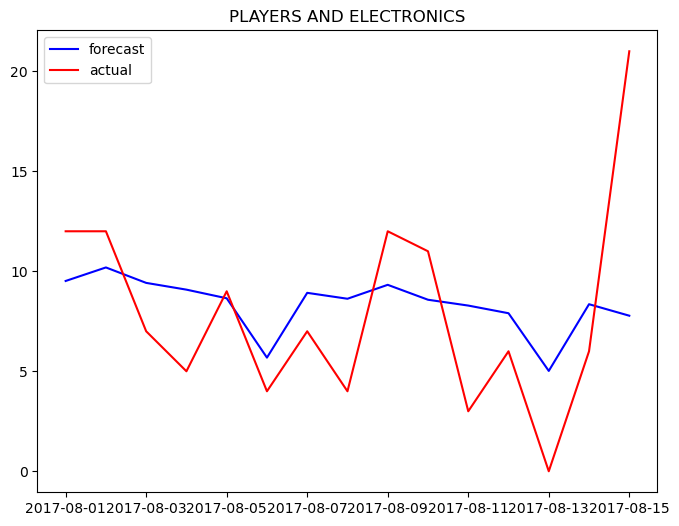

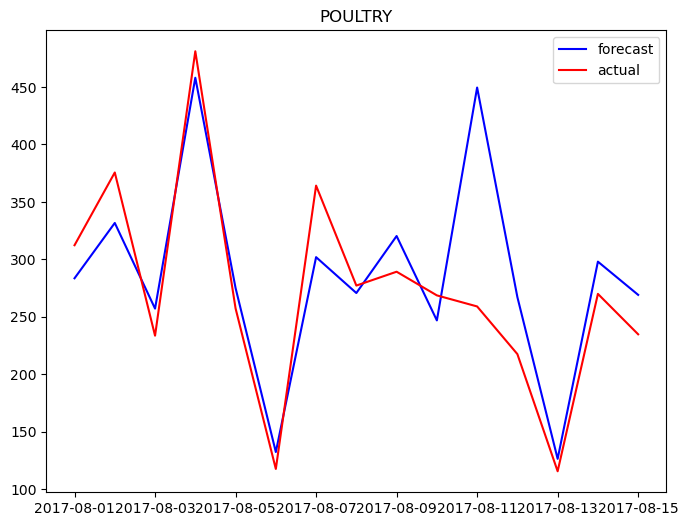

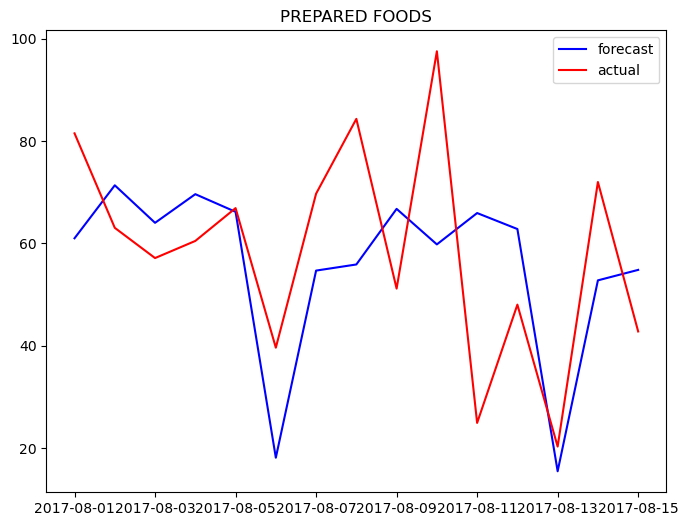

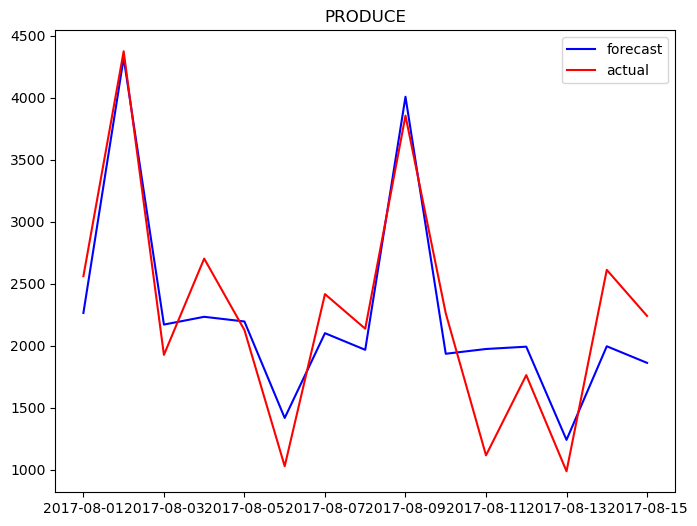

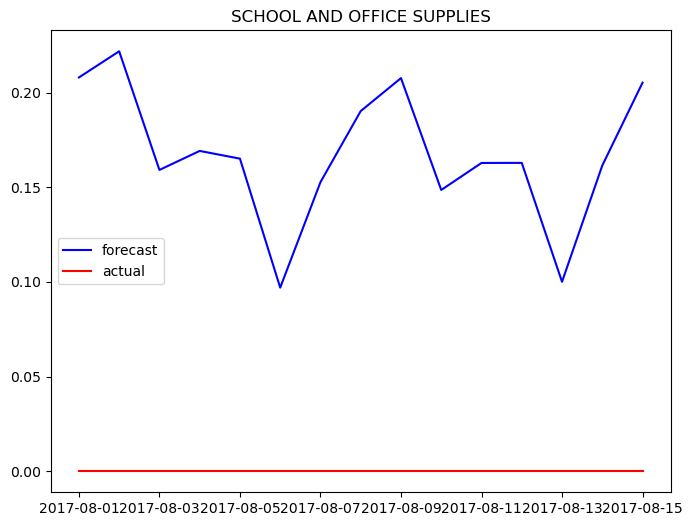

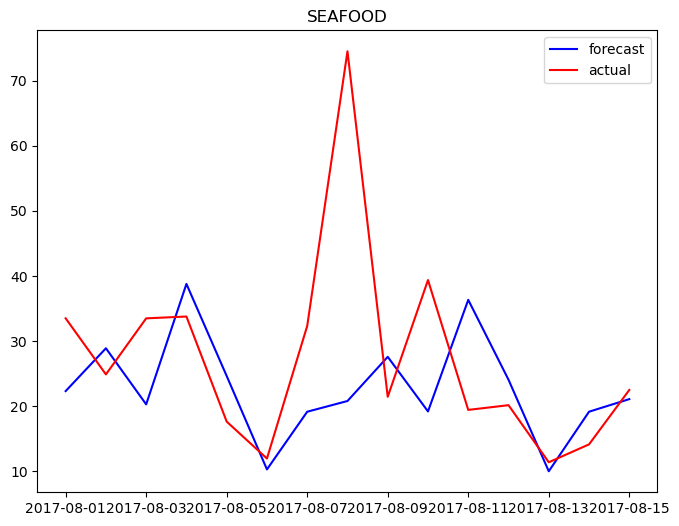

In [47]:
for family in result[0]:
    plt.figure(figsize=(8,6))
    plt.plot(result[0][family]['ds'], result[0][family]['yhat'], color = 'blue', label = 'forecast')
    plt.plot(result[0][family]['ds'], result[0][family]['y'], color = 'red', label = 'actual')
    plt.legend()
    plt.title(family)

In [228]:
# Median mean absolute percentage error of families of all store
mape_store = pd.DataFrame(columns = ['store', 'median_mape'])
i = 0
for store in train['store_nbr'].unique():
    result = get_forecasting(train, oil, store)
    median_mape = np.median(list(result[1].values()))
    mape_store.loc[i] = [store, median_mape]
    i += 1

Below are the median of mean absolute percentage error (mape) of all families of each store. We can see that some stores have high median mape compare to the others such as store 10, 14, 16, 18, 25, 26 which are around 0.5. These stores as I checked there are a lot of 0 in historical sale, which is difficult for model to forecast future sale.

In [229]:
mape_store

,store,median_mape
0,1.0,0.344382
1,10.0,0.569822
2,11.0,0.386672
3,12.0,0.432171
4,13.0,0.338056
5,14.0,0.472917
6,15.0,0.397920
7,16.0,0.516577
8,17.0,0.256231
9,18.0,0.453874
